# Fig1: Maps - bathymetry and temp anomaly
2019-12-10 18:28:06 

In [1]:
%matplotlib inline

import sys
sys.path.append("../")  # adds upper level to working directory
# somehow the other way does not work
from utils.orca_utilities import deseason_month,anomaly,load_orca_EIO,mean_LC_width
from utils.plot_utils import finished_plot

import matplotlib.pyplot as plt
import cmocean as cmo
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import warnings
warnings.filterwarnings("ignore")


################################
# path to save plots
plotsave = './plots/'


In [6]:
# # load ORCA data
k003ts,_,_ = load_orca_EIO('K003.hindcast')
# temp = k003ts['votemper'].sel(lon=slice(80,145),lat=slice(-41,20)).isel(deptht=0)

# load bathymetry
bathy = xr.open_dataset('../data/ORCA025.L46.LIM2vp.CFCSF6.JRA.XI0S2.bathymetry_EIO_grid_T.nc')

# derived from
# bathy = xr.open_dataset('/vortex/clidex/data/ORCA/mesh_files/mesh_zgr.nc')
# bathy = bathy['hdept']
# # cut bathy to match EIO region of new runs.
# xbnds,ybnds = [9,310],[297,625]

# # Leeuwin Current boundaries
# [tLC,LCw,LCe] = mean_LC_width(k003ts['votemper'])
# LC = tLC.to_dataset()
# LC['LCw'] = LCw
# LC['LCe'] = LCe
# LC.to_netcdf('../data/k003_LC.nc')
LC = xr.open_dataset('../data/k003_LC.nc')

# # temp anomaly from 2011 Ningaloo Nino
# temp2011 = np.squeeze(deseason_month(temp).sel(time_counter=slice('01-01-2011','02-01-2011'))).load()
# temp2011 = temp2011.where(temp2011!=0)
# temp2011.to_dataset().to_netcdf('../data/Fig1_temp_surface.nc')

# Load saved derived fields
temp2011 = xr.open_dataset('../data/Fig1_temp_surface.nc')

In [9]:
temp2011

<xarray.Dataset>
Dimensions:        (lat: 262, lon: 261)
Coordinates:
    deptht         float32 ...
  * lon            (lon) float32 80.0 80.25 80.5 80.75 ... 144.5 144.75 145.0
  * lat            (lat) float32 -40.979897 -40.790894 ... 19.605793 19.841127
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] ...
Data variables:
    votemper       (lat, lon) float32 ...

## plotting

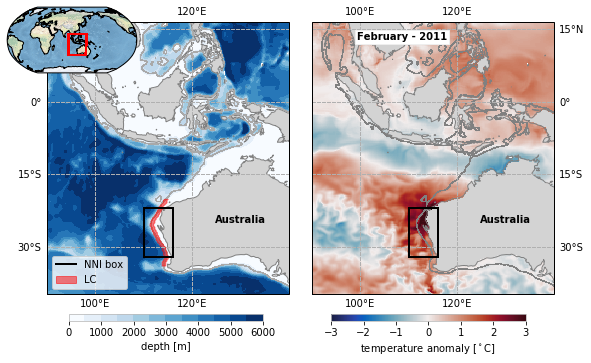

In [10]:
# define projection
proj = ccrs.PlateCarree()

plt.close('all')
fig,ax = plt.subplots(ncols=2,figsize=(9,5),subplot_kw = dict(projection=proj),constrained_layout=True)
plt.subplots_adjust(wspace=0.01,right=0.94)

# Bathymetry
cc= ax[0].contourf(bathy.lon,bathy.lat,bathy['bathyt'],levels=np.arange(0,6500,500),
                cmap=plt.get_cmap('Blues',len(np.arange(0,6500,500))-1),
                vmin=0,vmax=6000)
ax[0].contour(bathy.lon,bathy.lat,bathy['bathyt'],levels=[1000],colors='darkgray',linewidth=1)
# Temp
cc2= temp2011['votemper'].plot(ax=ax[1],add_colorbar=False,vmin=-3,vmax=3,cmap=plt.get_cmap('cmo.balance'))
ax[1].contour(bathy.lon,bathy.lat,bathy['bathyt'],levels=[1000],colors='gray',linewidth=1)

for i in range(2):
    ax[i].set_extent([90,140,-37,15])
    ax[i].coastlines(resolution='50m',color='gray')
    ax[i].add_feature(cartopy.feature.LAND, color='lightgray')
    gl = ax[i].gridlines(crs=proj,draw_labels=True,
                            xlocs=range(60,160,20),ylocs=range(-45,45,15))
    gl.yformatter = LATITUDE_FORMATTER
    gl.xformatter = LONGITUDE_FORMATTER
    if i==0: gl.ylabels_right = False
    else: gl.ylabels_left = False

    # NNI box
    lon_bnds,lat_bnds = [110,116],[-32,-22]
    ax[i].plot([lon_bnds[0], lon_bnds[0],lon_bnds[1],lon_bnds[1],lon_bnds[0]]
           ,[lat_bnds[0], lat_bnds[1],lat_bnds[1],lat_bnds[0],lat_bnds[0]],color='black',linewidth=1.5,label='NNI box')

    # add labels
    ax[i].text(130,-25,'Australia',weight='bold',horizontalalignment='center')
    ax[i].set_title('')

# add LC band
ll = ax[0].fill_betweenx(LC.lat,LC.LCw,LC.LCe,color='red',label='LC',zorder=2,alpha=0.5)
ax[0].legend(loc='lower left')


# colorbar
cbaxes = fig.add_axes([0.175, 0.05, 0.3, 0.02]) 
cb = plt.colorbar(cc,orientation='horizontal', cax = cbaxes,label='depth [m]') 
cb.ax.invert_yaxis()
cbaxes = fig.add_axes([0.58, 0.05, 0.3, 0.02]) 
cb = plt.colorbar(cc2,orientation='horizontal', cax = cbaxes,label='temperature anomaly [$^\circ$C]') 
cb.ax.invert_yaxis()
# cbaxes.yaxis.set_ticks_position('left')

# add mini world map
mapax = fig.add_axes([0.08,0.73,0.2,0.2],projection=ccrs.Robinson(central_longitude=100))
mapax.set_global()
mapax.stock_img()
mapax.coastlines()
lon_bnds,lat_bnds = [90,140],[-37,15]
mapax.plot([lon_bnds[0], lon_bnds[0],lon_bnds[1],lon_bnds[1],lon_bnds[0]]
       ,[lat_bnds[0], lat_bnds[1],lat_bnds[1],lat_bnds[0],lat_bnds[0]],color='red',linewidth=1.5,
           transform=proj)

# add annotation
t = plt.text(0.62, 0.83, 'February - 2011', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10)
t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))

# gl.xlabel_style, gl.ylabel_style = {'fontsize': 8}, {'fontsize': 8}
# plt.savefig(plotsave + 'fig1_map.eps',dpi=300,bbox_inches='tight')

# Hydrographic Sections

In [ ]:
# load ORCA section data
sec = xr.open_dataset('../data/sections/section_LC24S_K003.hindcast.nc')
import seawater as sw
sec['pden'] = (('time_counter','z','c'),np.transpose(sw.pden(sec['vosaline'].transpose('time_counter','c','z'),
                       sec['votemper'].transpose('time_counter','c','z'),sec.z,0),(0,2,1)))


# temp plus vel
plt.rcParams.update({'font.size':11})
levels=np.arange(4,27)

fig,ax = plt.subplots(figsize=(5,3))
cc= ax.contourf(sec.lon,sec.z,sec['votemper'].mean('time_counter'),levels=22,
                                                   xincrease=False,cmap=plt.get_cmap('cmo.thermal',len(levels)),vmin=4,vmax=25)
# plt.colorbar(cc,extend='max',label='temperature [$^\circ$C]')
cbaxes = fig.add_axes([0.77, 0.15, 0.02, 0.6])
cb = fig.colorbar(cc,cax=cbaxes,ticks=np.arange(5,30,5))
cb.set_label(label='temperature [\N{DEGREE SIGN}C]', size=9)
cb.ax.tick_params(labelsize=9)

# add vel
cc1 = ax.contour(sec.lon,sec.z,sec['u_normal'].mean('time_counter'),levels=np.arange(-0.3,0.32,0.02),
                                                   xincrease=False,cmap=plt.get_cmap('RdBu_r'),vmin=-0.2,vmax=0.2)
cc2 = ax.contour(sec.lon.where(sec.lon>=110),sec.z,sec['u_normal'].where(sec.lon>=110).mean('time_counter'),levels=0,
                                                   xincrease=False,colors='k',alpha=0.5,linewidth=0.5)

clabels=plt.clabel(cc2,[0],fmt='%1d',inline_spacing=2,inline=False,fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=1)) for txt in clabels]

ax.set_ylim(800,0)
ax.set_xlim(110,113.5)
ax.set_facecolor('darkgray')
ax.set_ylabel('depth [m]')
ax.set_xlabel('longitude [\N{DEGREE SIGN}E]')
ax.set_xticks(np.arange(110,114,1));
ax.set_xticklabels(['110\N{DEGREE SIGN}E','111\N{DEGREE SIGN}E','112\N{DEGREE SIGN}E','113\N{DEGREE SIGN}E']);

# finished_plot(fig,'/climodes/data4/sryan/plots_rev/sec24S_mean_temp_vel.png');

In [ ]:
# velocity 
plt.rcParams.update({'font.size':11})

levels=np.arange(4,27)
fig,ax = plt.subplots(figsize=(5,3))
cc= ax.contourf(sec.lon,sec.z,sec['u_normal'].mean('time_counter'),levels=30,
                xincrease=False,cmap=plt.get_cmap('cmo.balance',len(levels)),
                vmin=-0.2,vmax=0.2)
# plt.colorbar(cc,extend='max',label='temperature [$^\circ$C]')
cbaxes = fig.add_axes([0.74, 0.15, 0.02, 0.6])
cb = fig.colorbar(cc,cax=cbaxes,ticks=np.arange(-0.2,0.2,0.05))
cb.set_label(label='meridional vel. [m/s]', size=9)
cb.ax.tick_params(labelsize=9)

# add vel
# cc1 = ax.contour(sec.lon,sec.z,sec['u_normal'].mean('time_counter'),levels=np.arange(-0.3,0.32,0.02),
#                                                    xincrease=False,cmap=plt.get_cmap('RdBu_r'),vmin=-0.2,vmax=0.2)
cc2 = ax.contour(sec.lon.where(sec.lon>=110),sec.z,sec['u_normal'].where(sec.lon>=110).mean('time_counter'),levels=0,
                                                   xincrease=False,colors='k',alpha=0.5,linewidth=0.5)

clabels=plt.clabel(cc2,[0],fmt='%1d',inline_spacing=2,inline=False,fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=1)) for txt in clabels]

ax.set_ylim(800,0)
ax.set_xlim(110,113.5)
ax.set_facecolor('darkgray')
ax.set_ylabel('')
ax.set_xlabel('longitude [\N{DEGREE SIGN}E]')
ax.set_yticklabels('')
ax.set_xlabel('longitude [\N{DEGREE SIGN}E]')
ax.set_xticks(np.arange(110,114,1));
ax.set_xticklabels(['110\N{DEGREE SIGN}E','111\N{DEGREE SIGN}E','112\N{DEGREE SIGN}E','113\N{DEGREE SIGN}E'])


# finished_plot(fig,'/climodes/data4/sryan/plots_rev/sec24S_mean_vel.png');